In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from HomoTopiContinuation.DataStructures.datastructures import Conic, Conics, Circle, Homography
from HomoTopiContinuation.SceneGenerator.scene_generator import SceneDescription, SceneGenerator

from HomoTopiContinuation.Rectifier.homotopyc_rectifier import HomotopyContinuationRectifier
from HomoTopiContinuation.ConicWarper.ConicWarper import ConicWarper

from HomoTopiContinuation.Losser.CircleLosser  import CircleLosser
from HomoTopiContinuation.Plotter.Plotter import Plotter

In [16]:
def sceneDefinition() -> SceneDescription:
    # Parameters
    f = 2
    theta = 30

    # Define the circles
    c1 = Circle(
        np.array([4, 4]), 1)
    c2 = Circle(
        np.array([3, 1]), 1)
    c3 = Circle(
        np.array([5, 1]), 1)

    print("Circle 1:")
    print(c1.to_conic().M)
    print([float(p) for p in c1.to_conic().to_algebraic_form()])
    print("Circle 2:")
    print(c2.to_conic().M)
    print([float(p) for p in c2.to_conic().to_algebraic_form()])
    print("Circle 3:")
    print(c3.to_conic().M)
    print([float(p) for p in c3.to_conic().to_algebraic_form()])

    offset = np.array([0, 0, 2])
    noiseScale = 0

    return SceneDescription(f, theta, offset, c1, c2, c3, noiseScale)

Circle 1:
[[ 1  0 -4]
 [ 0  1 -4]
 [-4 -4 31]]
[1.0, 0.0, 1.0, -8.0, -8.0, 31.0]
Circle 2:
[[ 1  0 -3]
 [ 0  1 -1]
 [-3 -1  9]]
[1.0, 0.0, 1.0, -6.0, -2.0, 9.0]
Circle 3:
[[ 1  0 -5]
 [ 0  1 -1]
 [-5 -1 25]]
[1.0, 0.0, 1.0, -10.0, -2.0, 25.0]
No distortion params provided, using true conics


c:\polimi\master\2sem\cv_homotopy_project\repo\src\HomoTopiContinuation\Plotter\Plotter.py:80: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax.legend()


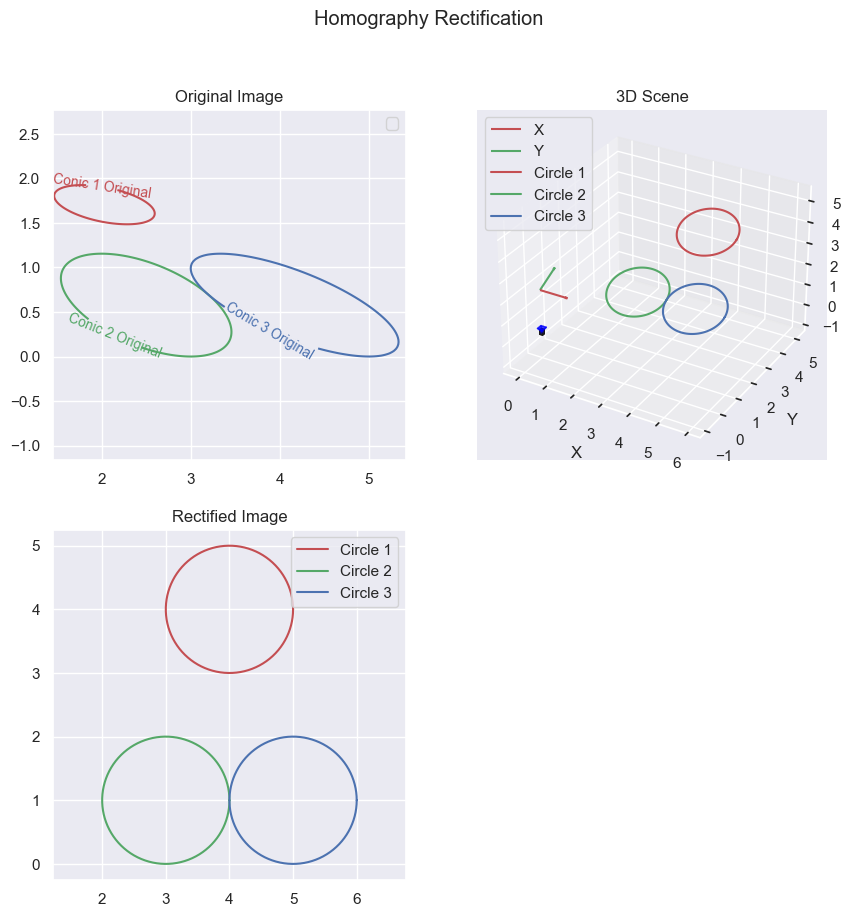

In [17]:
sceneDescription = sceneDefinition()

img = SceneGenerator().generate_scene(sceneDescription, debug=True)

H = img.h_true

plotter = Plotter(2, 2, figsize=(10, 10), title="Homography Rectification")
plotter.plotScene(
    sceneDescription=sceneDescription,
    img=img,
    name="Original Scene"
)

In [18]:
# compute the images of the circular points
I = np.array([1,1j,0])
J = np.array([1,-1j,0])

I_img = H.H @ I
J_img = H.H @ J

I_img = I_img / I_img[0]
J_img = J_img / J_img[0]

print(I_img)
print(J_img)


[1.+0.j        0.+0.8660254j 0.+0.25j     ]
[1.+0.j        0.-0.8660254j 0.-0.25j     ]


In [19]:
def perturb_circular_points(I_img, J_img, noise_scale):
    # Perturb the circular points
    I_img_perturbed = I_img + (np.random.normal(0, noise_scale, I_img.shape) + 1j*np.random.normal(0, noise_scale, I_img.shape))
    J_img_perturbed = J_img + (np.random.normal(0, noise_scale, J_img.shape) + 1j*np.random.normal(0, noise_scale, J_img.shape))
    return I_img_perturbed, J_img_perturbed


In [49]:
from tqdm.notebook import tqdm
rectifier = HomotopyContinuationRectifier()
losser = CircleLosser

N_ITER = 100
N_PERTURBATION_STEPS = 500
losses = np.zeros(N_ITER * N_PERTURBATION_STEPS)
#perturbation_steps = np.linspace(1e-6, 1e-3, N_PERTURBATION_STEPS)
# logartimic scale
MINLOGDELTA = -9
MAXLOGDELTA = 1
perturbation_steps = np.logspace(MINLOGDELTA, MAXLOGDELTA, N_PERTURBATION_STEPS)
deltas = []
losses = []

warpedConicsHistory = []


for i, perturbation_scale in tqdm(enumerate(perturbation_steps), total=N_PERTURBATION_STEPS, desc="Perturbation Scales", position=0):
    for j in tqdm(range(N_ITER), desc="Iterations", position=1, leave=False):
        # get perturbed points
        I_img_perturbed, J_img_perturbed = perturb_circular_points(I_img, J_img, perturbation_scale)
        delta = [
            np.linalg.norm(I_img_perturbed - I_img),
            np.linalg.norm(J_img_perturbed - J_img)
        ]
        deltas.append(delta)
        # Apply SVD reconstruction starting from the perturbed points
        imDCCP = rectifier.compute_imDCCP_from_solutions(sols=np.array([I_img_perturbed, J_img_perturbed]))
        H_inv_computed = rectifier._compute_h_from_svd(imDCCP=imDCCP)
        # project the circles back
        warpedConics = ConicWarper().warpConics(img.C_img, H_inv_computed)
        warpedConicsHistory.append(warpedConics)
        loss = losser.computeCircleLoss(sceneDescription, warpedConics)
        #if (np.imag(np.max(loss)) < 1e-6):
        losses.append(loss)

losses = np.abs(np.array(losses))
deltas = np.array(deltas)

avgLoss = np.mean(losses, axis=-1)
avgDelta = np.mean(deltas, axis=-1)


Perturbation Scales:   0%|          | 0/500 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

In [50]:
np.max(losses), np.min(losses), np.mean(losses), np.std(losses)

(np.float64(399.2950571703822),
 np.float64(5.237816449772962e-06),
 np.float64(0.8402150286869685),
 np.float64(2.7987430383622884))

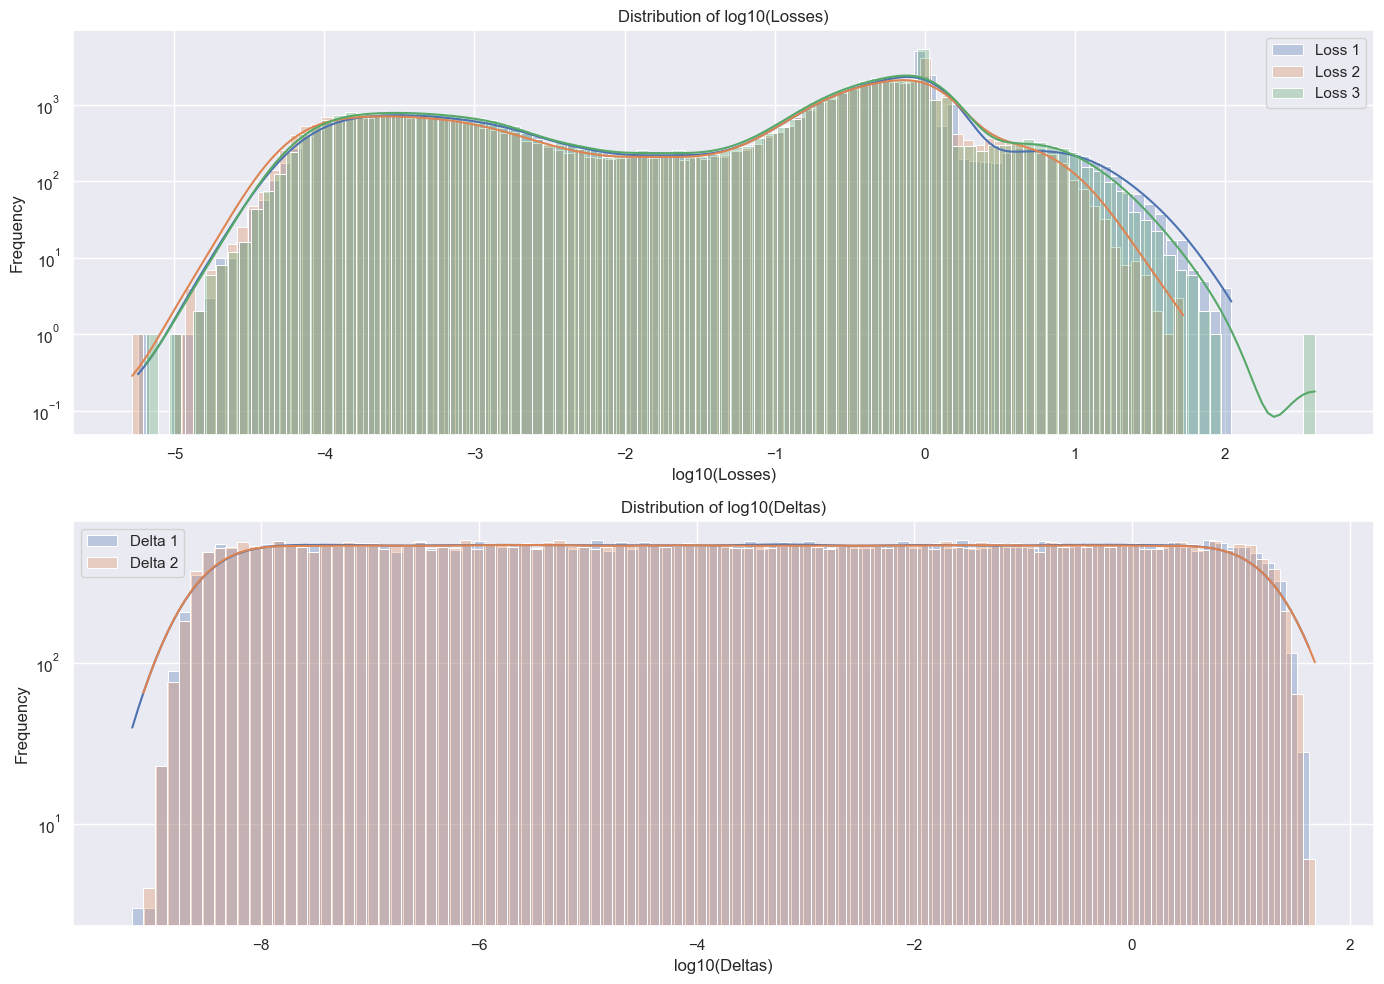

In [51]:
fig, axs = plt.subplots(2, 1, figsize=(14, 10))
for idx in range(losses.shape[1]):
    sns.histplot(np.log10(np.abs(losses[:, idx])), bins=100, alpha=0.3, label=f'Loss {idx+1}', kde=True, ax=axs[0])
axs[0].set_xlabel('log10(Losses)')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of log10(Losses)')
axs[0].set_yscale('log')
axs[0].legend()

for idx in range(deltas.shape[1]):
    sns.histplot(np.log10(np.abs(deltas[:, idx])), bins=100, alpha=0.3, label=f'Delta {idx+1}', kde=True, ax=axs[1])
axs[1].set_xlabel('log10(Deltas)')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of log10(Deltas)')
axs[1].set_yscale('log')
axs[1].legend()

plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

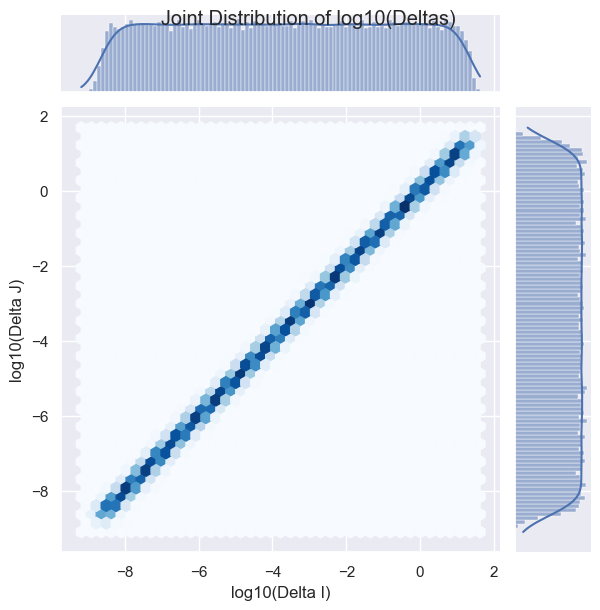

In [52]:
# Plot the joint distribution of the two deltas
plt.figure(figsize=(8, 6))
sns.jointplot(x=np.log10(deltas[:, 0]), y=np.log10(deltas[:, 1]), kind='hex', cmap='Blues', marginal_kws=dict(bins=100, fill=True, kde=True))
plt.xlabel('log10(Delta I)')
plt.ylabel('log10(Delta J)')
plt.suptitle('Joint Distribution of log10(Deltas)')
plt.show()

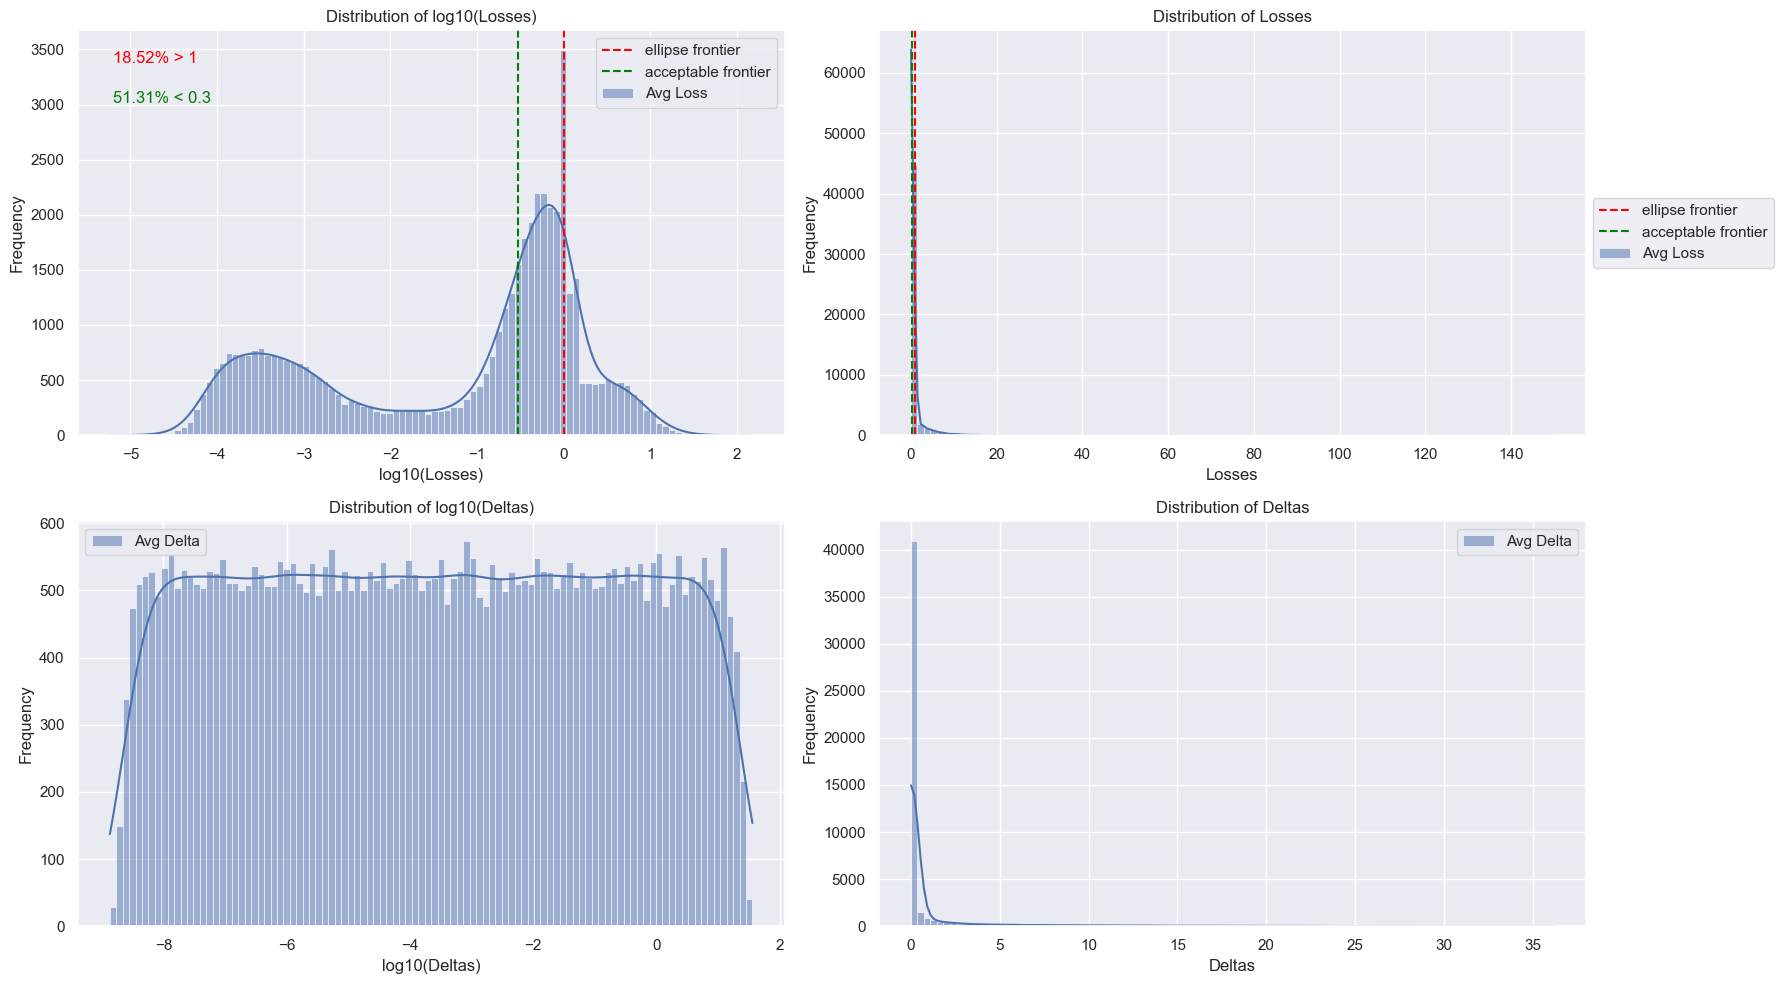

In [53]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# Avg Loss - log10 x-axis
sns.histplot(np.log10(np.abs(avgLoss)), bins=100, label='Avg Loss', kde=True, ax=axs[0, 0])
axs[0, 0].set_xlabel('log10(Losses)')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].set_title('Distribution of log10(Losses)')
# axs[0, 0].set_yscale('log')
# Add vertical lines at loss=1 (log10(1)=0) and loss=0.3 (log10(0.3))
axs[0, 0].axvline(np.log10(1), color='red', linestyle='--', label='ellipse frontier')
axs[0, 0].axvline(np.log10(0.3), color='green', linestyle='--', label='acceptable frontier')
# Calculate and annotate percentages
pct_above_1 = 100 * np.mean(avgLoss > 1)
pct_below_03 = 100 * np.mean(avgLoss < 0.3)
axs[0, 0].text(0.05, 0.95, f'{pct_above_1:.2f}% > 1', transform=axs[0, 0].transAxes, fontsize=12, verticalalignment='top', color='red')
axs[0, 0].text(0.05, 0.85, f'{pct_below_03:.2f}% < 0.3', transform=axs[0, 0].transAxes, fontsize=12, verticalalignment='top', color='green')
axs[0, 0].legend()

# Avg Loss - linear x-axis
sns.histplot(np.abs(avgLoss), bins=100, label='Avg Loss', kde=True, ax=axs[0, 1])
axs[0, 1].set_xlabel('Losses')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].set_title('Distribution of Losses')
axs[0, 1].axvline(1, color='red', linestyle='--', label='ellipse frontier')
axs[0, 1].axvline(0.3, color='green', linestyle='--', label='acceptable frontier')
axs[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Avg Delta - log10 x-axis
sns.histplot(np.log10(np.abs(avgDelta)), bins=100, label='Avg Delta', kde=True, ax=axs[1, 0])
axs[1, 0].set_xlabel('log10(Deltas)')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].set_title('Distribution of log10(Deltas)')
# axs[1, 0].set_yscale('log')
axs[1, 0].legend()

# Avg Delta - linear x-axis
sns.histplot(np.abs(avgDelta), bins=100, label='Avg Delta', kde=True, ax=axs[1, 1])
axs[1, 1].set_xlabel('Deltas')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_title('Distribution of Deltas')
# axs[1, 1].set_yscale('log')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

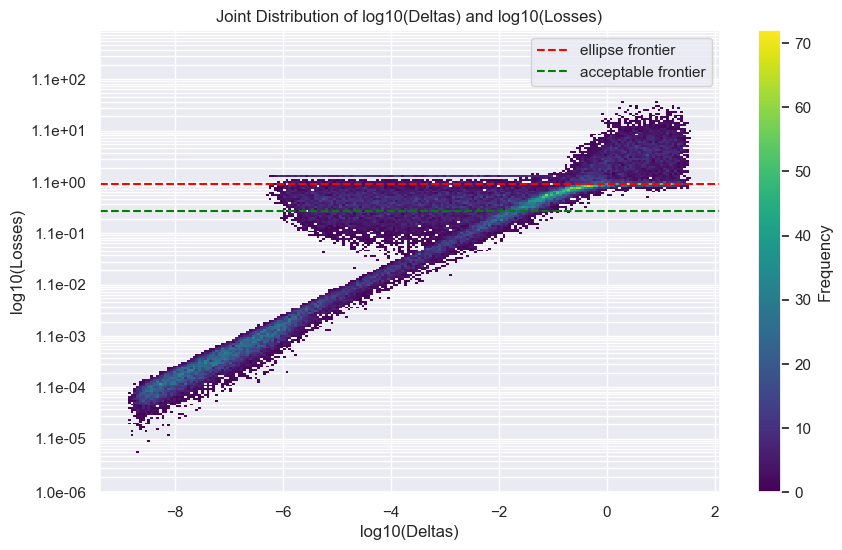

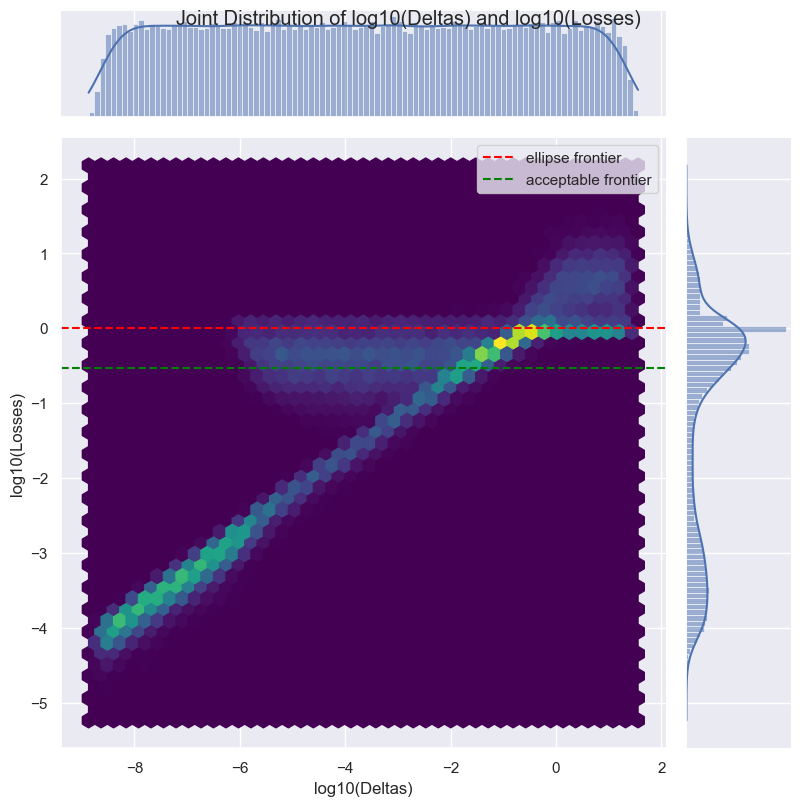

In [54]:
# Plot the histogram of the joint distribution of deltas and losses
plt.figure(figsize=(10, 6))
sns.histplot(x=np.log10(avgDelta), y=np.log10(avgLoss), bins=200, cmap='viridis', cbar=True, cbar_kws={'label': 'Frequency'})
plt.xlabel('log10(Deltas)')
plt.ylabel('log10(Losses)')
plt.title('Joint Distribution of log10(Deltas) and log10(Losses)')
plt.axhline(np.log10(1), color='red', linestyle='--', label='ellipse frontier')
plt.axhline(np.log10(0.3), color='green', linestyle='--', label='acceptable frontier')
# For y-axis (Losses)
ticks = np.linspace(0, 9, 10)
minLogDelta = -6
maxLogDelta = int(np.ceil(np.log10(np.max(avgDelta))))
exponents = np.linspace(minLogDelta, maxLogDelta, maxLogDelta - minLogDelta + 1)
basis = 10 ** exponents
basisCumSum = np.cumsum(basis)
shiftedTicks = np.concatenate([ticks * (10 ** e) + basisCumSum[i] for i, e in enumerate(exponents)])
y_ticks_log = np.log10(shiftedTicks)
plt.yticks(y_ticks_log, [f"{tick:.1e}" if (i)%10 == 0 else "" for i, tick in enumerate(shiftedTicks)])

plt.grid(True, which='both', axis='both')
plt.legend()
plt.show()

# joint plot of deltas and losses
g = sns.jointplot(
    x=np.log10(avgDelta),
    y=np.log10(avgLoss),
    kind='hex',
    cmap='viridis',
    marginal_kws=dict(bins=100, fill=True, kde=True),
    height=8,
)
g.ax_joint.axhline(np.log10(1), color='red', linestyle='--', label='ellipse frontier')
g.ax_joint.axhline(np.log10(0.3), color='green', linestyle='--', label='acceptable frontier')
g.ax_joint.legend()
g.set_axis_labels('log10(Deltas)', 'log10(Losses)')
plt.suptitle('Joint Distribution of log10(Deltas) and log10(Losses)')
plt.grid(True, which='both', axis='both')
plt.show()


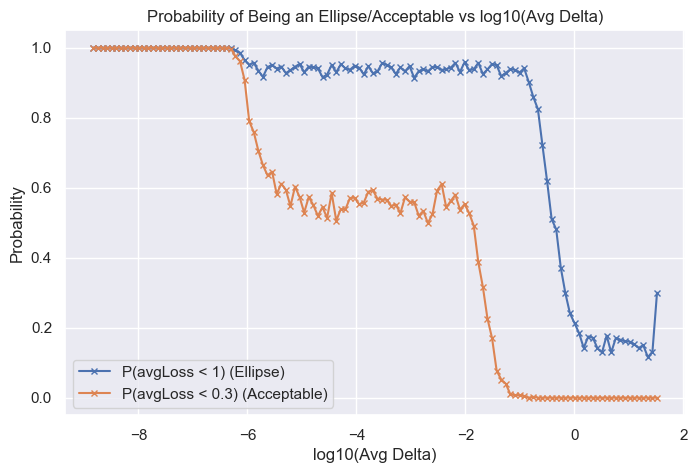

In [55]:
# Bin the log10 of the average delta
log_avgDelta = np.log10(np.abs(avgDelta))
bins = np.linspace(log_avgDelta.min(), log_avgDelta.max(), N_PERTURBATION_STEPS//4)
bin_indices = np.digitize(log_avgDelta, bins)

# For each bin, compute the probability that avgLoss < 1 (ellipse) and avgLoss < 0.3 (acceptable)
prob_ellipse = []
prob_acceptable = []
bin_centers = []
for i in range(1, len(bins)):
    in_bin = (bin_indices == i)
    if np.any(in_bin):
        prob_ellipse.append(np.mean(avgLoss[in_bin] < 1))
        prob_acceptable.append(np.mean(avgLoss[in_bin] < 0.3))
        bin_centers.append((bins[i-1] + bins[i]) / 2)

# Plot both probabilities as a function of log10(avgDelta)
plt.figure(figsize=(8, 5))
plt.plot(bin_centers, prob_ellipse, marker='x', label='P(avgLoss < 1) (Ellipse)', markersize=4)
plt.plot(bin_centers, prob_acceptable, marker='x', label='P(avgLoss < 0.3) (Acceptable)', markersize=4)
plt.xlabel('log10(Avg Delta)')
plt.ylabel('Probability')
plt.title('Probability of Being an Ellipse/Acceptable vs log10(Avg Delta)')
plt.grid(True)
plt.legend()
plt.show()

Plotting C1:   0%|          | 0/1000 [00:00<?, ?it/s]

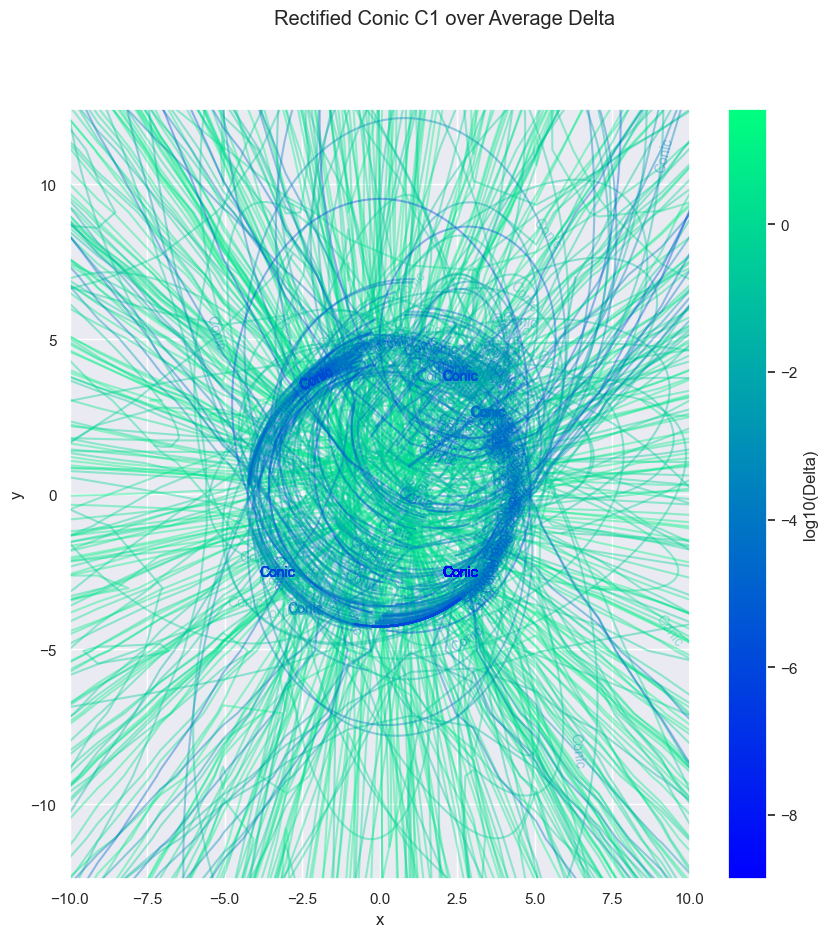

Plotting C2:   0%|          | 0/1000 [00:00<?, ?it/s]

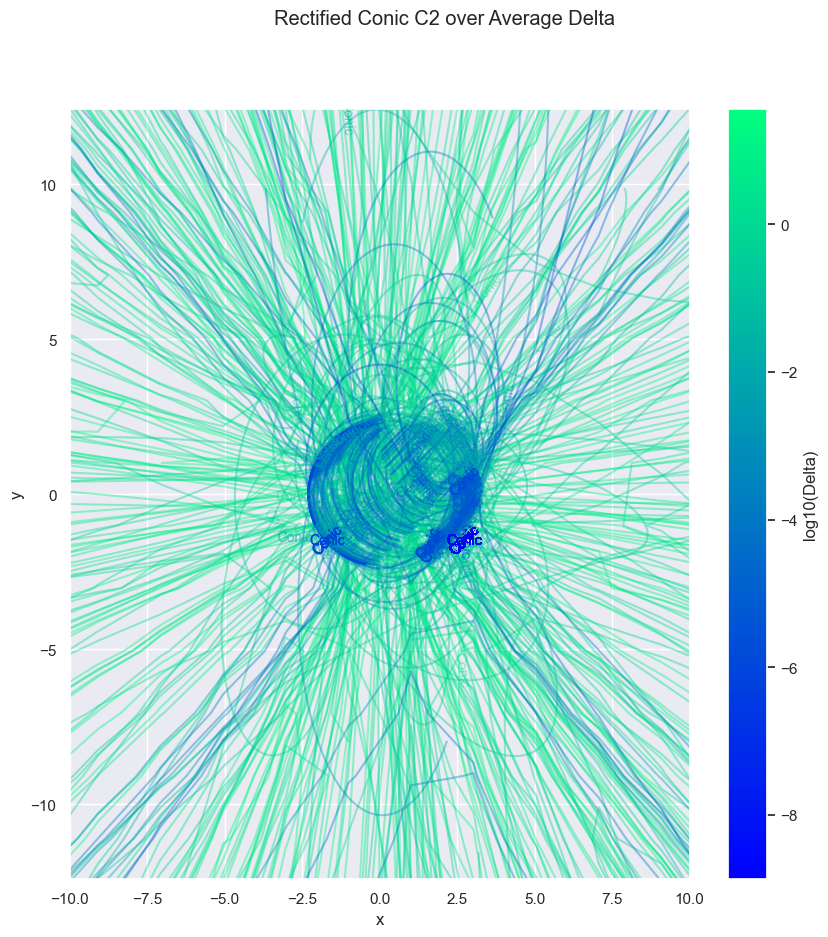

Plotting C3:   0%|          | 0/1000 [00:00<?, ?it/s]

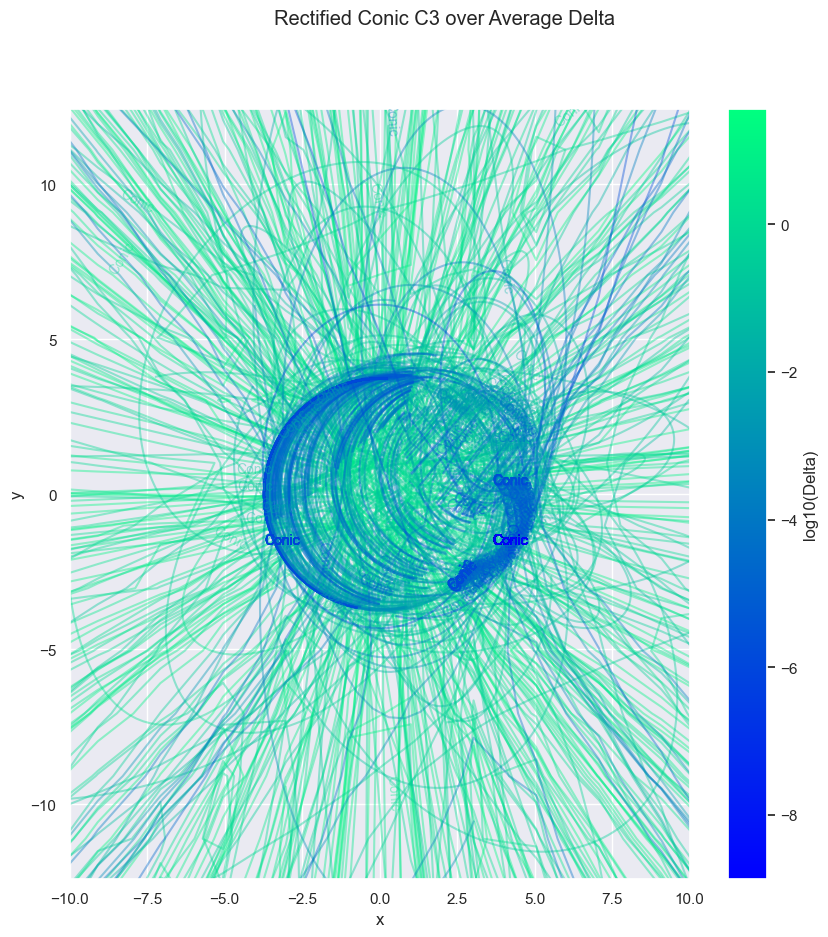

In [56]:
from tqdm.notebook import tqdm
def plot_rectified_conic_over_delta(warpedConicsHistory, avgDelta, circle_attr, title):
    plotter = Plotter(1, 1, title=title, figsize=(10, 10))
    plotter.newAxis()

    logDeltas = np.log10(np.abs(avgDelta))

    plotN = 10000
    plotEvery = 50  # Plot every nth iteration

    palette = sns.color_palette("winter", as_cmap=True)
    norm = plt.Normalize(logDeltas.min(), logDeltas.max())
    colors = palette(norm(logDeltas[::-1][:plotN*plotEvery][::plotEvery]))

    for idx, warpedConics in enumerate(tqdm(warpedConicsHistory[::-1][:plotN*plotEvery][::plotEvery], position=0, leave=False, desc=f"Plotting {circle_attr}")):
        color = colors[idx]
        conic = getattr(warpedConics, circle_attr)
        conic.M = np.real(conic.M)
        plotter.plotConic2D(conic, color=color, alpha=0.4)

    ax = plotter.getCurrentAxis()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='log10(Delta)')

    plotter.show()

# Apply to all three circles
plot_rectified_conic_over_delta(warpedConicsHistory, avgDelta, 'C1', "Rectified Conic C1 over Average Delta")
plot_rectified_conic_over_delta(warpedConicsHistory, avgDelta, 'C2', "Rectified Conic C2 over Average Delta")
plot_rectified_conic_over_delta(warpedConicsHistory, avgDelta, 'C3', "Rectified Conic C3 over Average Delta")
